# Fit an image model to ALMA uv data for HR 4796A's debris ring
The data here have been heavily cut down to keep the size manageable. A typical size might be more like 100MB. This notebook takes about a minute to execute on a decent iMac.

In [1]:
import os
import numpy as np
import emcee
import scipy.optimize
import matplotlib.pyplot as plt
import corner
import galario.double as gd
from galario import arcsec

import alma.image

%matplotlib notebook

In [2]:
# this may be needed to avoid emcee hanging when using multiple threads
# gd.threads(num=1)

## creating the uv table
This can be exported from the measurement set (ms) file using uvplot from within CASA. The ms file is first created from the full ms by keeping only the target of interest and the intents that observe it, and averaging the CO J=3-2 spectral window down to 128 channels, the same as the other three. The column with the data after this step is 'data'.

We then export from CASA with uvplot. To cut the data down we set spw=0, timebin=30s, and width=64 in the split command. We specify and keep the outputvis file, as this is what we will subtract the results of the modelling from to make a residual plot.

```python
import uvplot
uvplot.io.export_uvtable('uv-spw0-w64-t30.txt', tb, vis='calibrated_cont_selfcal.ms',
                         split=split, keep_tmp_ms=True, datacolumn='DATA',
                         channel='all',
                         split_args={'vis':'calibrated_cont_selfcal.ms',                            
                                     'spw':'0', 'keepflags':False, 'timebin':'30s', 'width':64,       
                                     'outputvis':'calibrated_cont_selfcal.spw0.w64-t30.ms',
                                     'datacolumn':'DATA'                                   
                                    }                   
                        )    
```

In [3]:
# import the data, this assumes we're getting the output from uvplot
uv_file = 'hr4796-uv-spw0-w64-t30s.txt'
u, v, Re, Im, w = np.require( np.loadtxt(uv_file, unpack=True),requirements=["C_CONTIGUOUS"])

# meaning we can get the mean wavelength like so
with open(uv_file) as f:
    _ = f.readline()
    tmp = f.readline()

wavelength = float(tmp.strip().split('=')[1])
print('wavelength is {} mm'.format(wavelength*1e3))
    
u /= wavelength
v /= wavelength

# re-weight so that chi^2 for null model is 1
reweight_factor = np.sum( ( Re**2.0 + Im**2.0) * w ) / len(w)
print('reweighting factor is {}'.format(reweight_factor))
w /= reweight_factor

wavelength is 0.862060468322 mm
reweighting factor is 3.4977166972136815


In [4]:
# set image properties, can alter f_max for higher or lower resolution
# (here 1.25 instead of 2.5, which gives speed at the cost of reduced accuracy)
nxy, dxy = gd.get_image_size(u, v, verbose=True, f_max=1.25)
dxy_arcsec = dxy / arcsec

dxy:3.525417e-02arcsec	nxy_MRS:1024
nxy_MRS: matrix size to have FOV > f_min * MRS, where f_min:5.0 and MRS:7.220054e+00arcsec


In [5]:
# decide what model we want to use, and where we will put the results
model_name = 'gauss_3d'
if not os.path.exists(model_name):
    os.mkdir(model_name)

In [6]:
# make the image object. by default this is asisymmetric
# (i.e. model='los_image_axisym', and has no anomaly parameter)
ii = alma.image.Image(arcsec_pix=dxy_arcsec, image_size=(nxy, nxy),
                      dens_model=model_name, z_fact=1, wavelength=wavelength)

model:los_image_axisym with density:gauss_3d and emit:rj_tail
parameters are ['$x_0$', '$y_0$', '$\\Omega$', '$i$', '$F$', '$r_0$', '$\\sigma_r$', '$\\sigma_h$']
rmax not set, run compute_rmax before generating images


In [ ]:
# or we could make an image object with a custom density,
# here an eccentric ring that uses a non-axisymmetric function
# for this we would set 'model_name' above to 'custom_2d'
def dfunc(r,az,el,p):
    r_ecc = p[0] * ( 1 - p[1]**2 ) / ( 1 + p[1]*np.cos(az) )
    return np.exp( -0.5*( (r-r_ecc)/p[2] )**2 ) * \
           np.exp( -0.5*( el/0.05 )**2 ) * \
           (1 - p[1]*np.cos(az))

ii = alma.image.Image(arcsec_pix=dxy_arcsec, image_size=(nxy, nxy),
                      model='los_image', z_fact=2, wavelength=wavelength,
                      dens_model=model_name,
                      dens_args={'func':dfunc,
                                 'params':['$a$','$e$','$\sigma_r$'],
                                 'p_ranges':[[0.001,1],[0.,1],[0.001,1]]})

In [7]:
# initial parameters, these need to be guessed
p0 = [-0.002, -0.052, 26.0, 78, 0.014, 1., 0.1]

if model_name == 'gauss_3d':     p0 += [0.1]
if model_name == 'custom_2d':    p0 = [-0.002, -0.052, 26.0, -70.0, 78, 0.014, 1., 0.1, 0.1]

p0 = np.array(p0)
    
print('parameters and ranges for {}'.format(model_name))
for i in range(ii.n_params):
    print('{}\t{}\t{}'.format(p0[i],ii.p_ranges[i],ii.params[i]))

parameters and ranges for gauss_3d
-0.002	[-inf, inf]	$x_0$
-0.052	[-inf, inf]	$y_0$
26.0	[-270, 270]	$\Omega$
78.0	[0.0, 120]	$i$
0.014	[0.0, inf]	$F$
1.0	[0.0, inf]	$r_0$
0.1	[0.001, inf]	$\sigma_r$
0.1	[0.01, 1.0]	$\sigma_h$


radial r_max: 36 pix at -0.05673087832899879,-1.4750028365539685
model x,y,z extent 14, 37, 36
16.5 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<IPython.core.display.Javascript object>


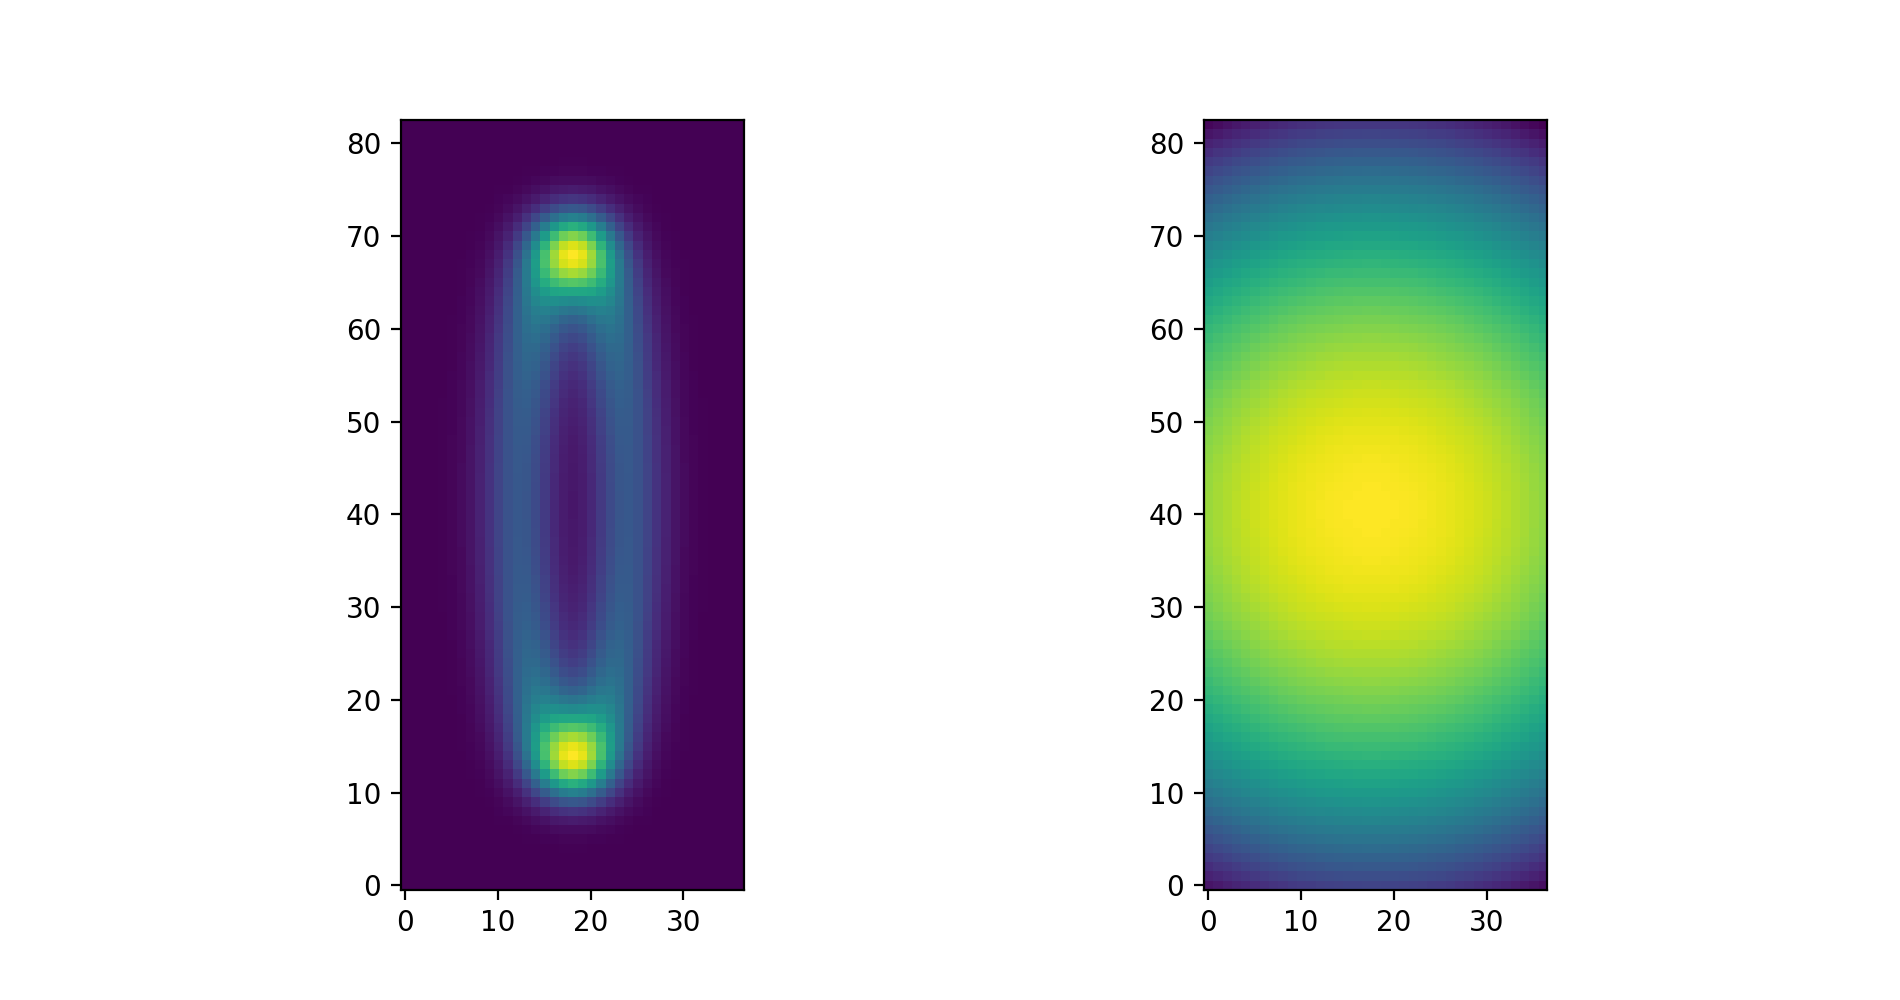

In [8]:
# set size of cutout used to generate images, which is based on the
# initial parameters. The tolerance in compute_rmax might be
# varied if the crop size turns out too large. We set 'zero_node'
# to True because we'll generate unrotated images, and let galario
# do the rest
ii.compute_rmax(p0, tol=1e-2, expand=5, zero_node=True)

# this gives an idea of how long an mcmc might take
%timeit ii.image_galario(p0[3:])

# show an image and the primary beam
im = ii.image_galario(p0[3:])
fig,ax = plt.subplots(1,2, figsize=(9.5,5))
ax[0].imshow(im[ii.cc_gal], origin='bottom')
ax[1].imshow(ii.pb[ii.cc_gal], origin='bottom')

In [9]:
def lnpostfn(p):
    """ Log of posterior probability function """

    for x,r in zip(p,ii.p_ranges):
        if x < r[0] or x > r[1]:
            return -np.inf

    # we generate the image with PA = North, origin in lower left,
    # and including primary beam correction
    image = ii.image_galario(p[3:]) * ii.pb_galario
    
    # galario translates and rotates it for us
    chi2 = gd.chi2Image(image, dxy, u, v, Re, Im, w, origin='lower',
                        dRA = p[0]*arcsec, dDec = p[1]*arcsec, PA = np.deg2rad(p[2]) )
    return -0.5 * chi2

nlnpostfn = lambda p: -lnpostfn(p)

[-2.24927023e-03 -3.63442277e-02  2.62873769e+01  7.62198126e+01
  1.72997651e-02  1.06885744e+00  8.99625921e-02  6.87625233e-02]


<IPython.core.display.Javascript object>


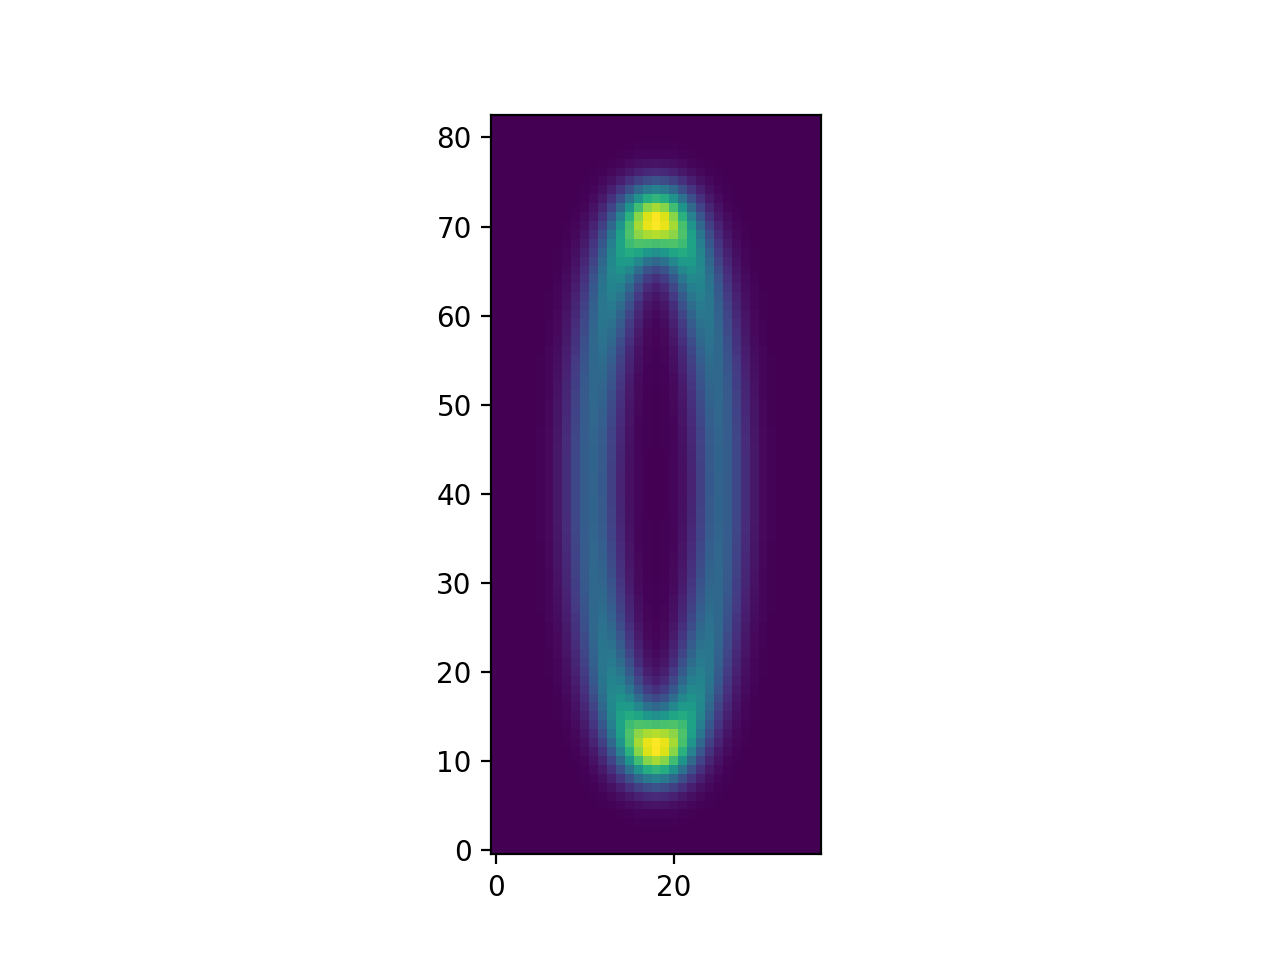

In [10]:
# get a best fit to estimate mcmc starting params
res = scipy.optimize.minimize(nlnpostfn, p0, method='Nelder-Mead',
                             options={'maxiter':100})
print(res['x'])
p0 = np.array(res['x'])

# show the image, before translation and rotation
im = ii.image_galario(p0[3:])
fig,ax = plt.subplots()
ax.imshow(im[ii.cc_gal],origin='bottom')

In [11]:
# set up and run mcmc fitting
ndim = ii.n_params        # number of dimensions
nwalkers = 16             # number of walkers
nsteps = 500              # total number of MCMC steps
nthreads = 8              # CPU threads that emcee should use

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpostfn, threads=nthreads)

# initialize the walkers with an ndim-dimensional Gaussian ball
pos = [p0 + p0*0.01*np.random.randn(ndim) for i in range(nwalkers)]

# execute the MCMC
pos, prob, state = sampler.run_mcmc(pos, nsteps)

<IPython.core.display.Javascript object>


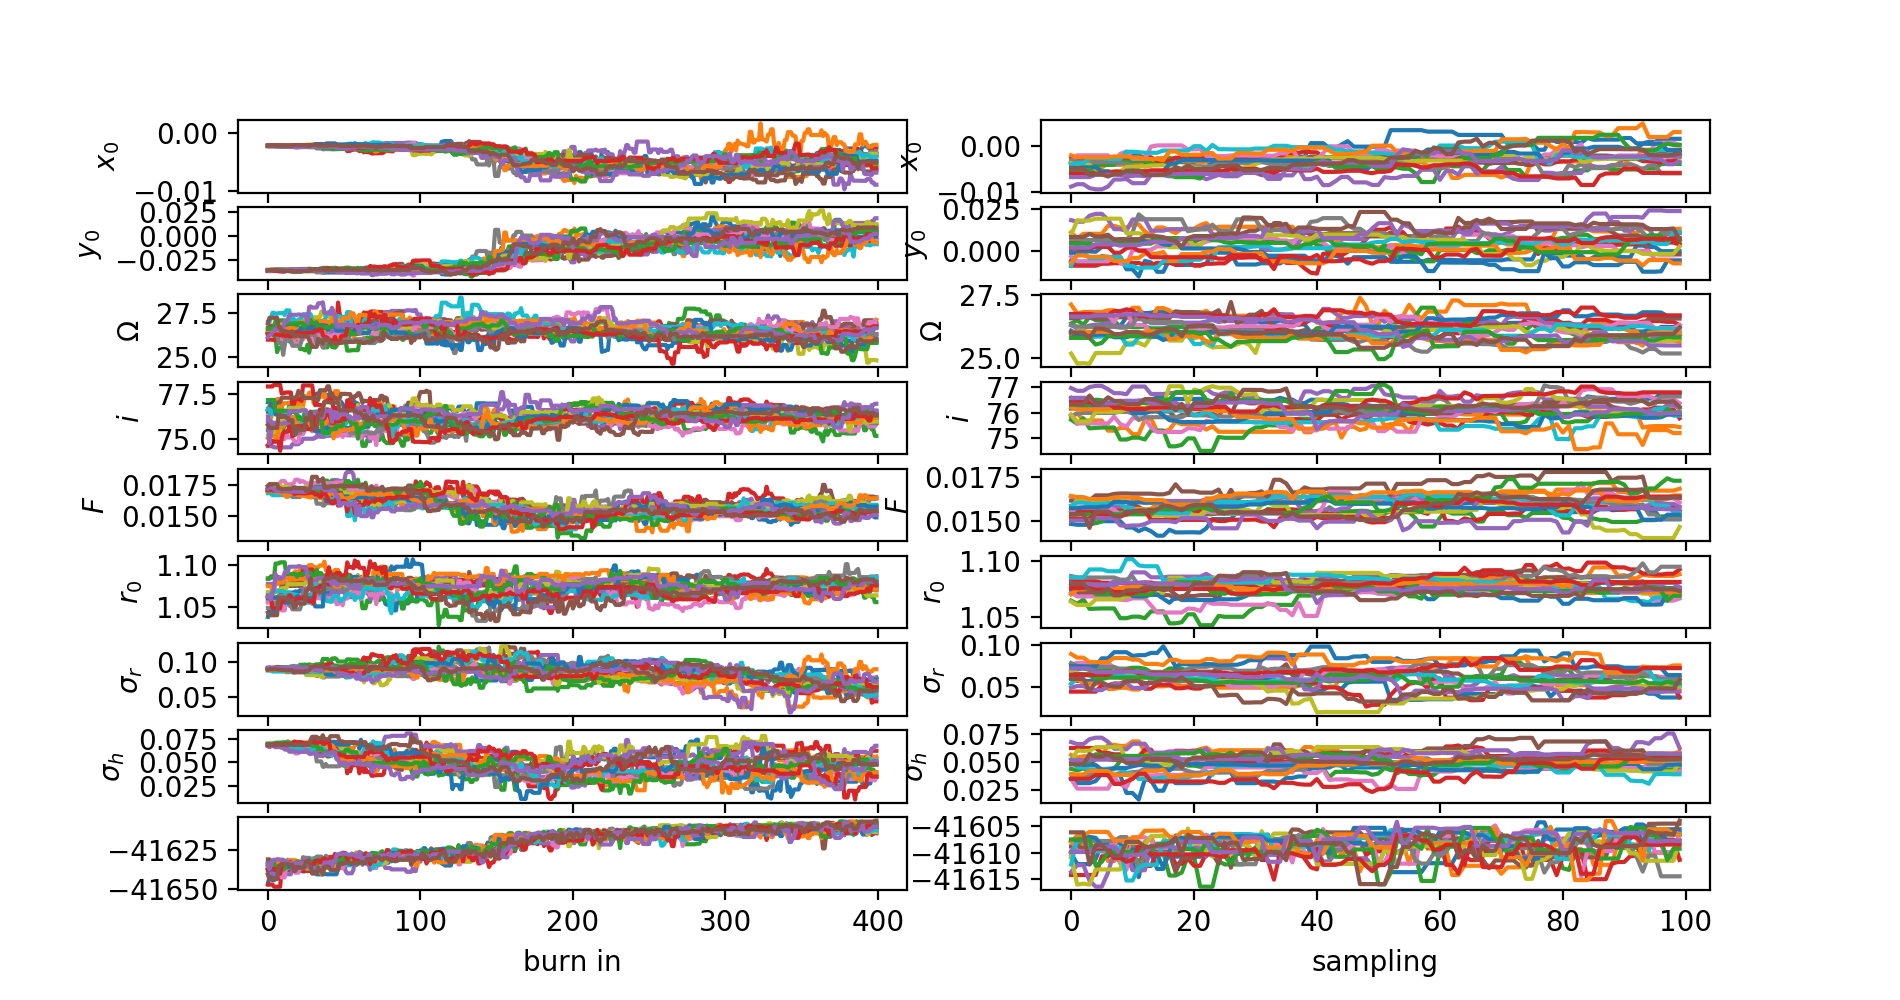

In [12]:
# see what the chains look like, skip a burn in period if desired
burn = 400
fig,ax = plt.subplots(ndim+1,2,figsize=(9.5,5),sharex='col',sharey=False)

for j in range(nwalkers):
    ax[-1,0].plot(sampler.lnprobability[j,:burn])
    for i in range(ndim):
        ax[i,0].plot(sampler.chain[j,:burn,i])
        ax[i,0].set_ylabel(ii.params[i])

for j in range(nwalkers):
    ax[-1,1].plot(sampler.lnprobability[j,burn:])
    for i in range(ndim):
        ax[i,1].plot(sampler.chain[j,burn:,i])
        ax[i,1].set_ylabel(ii.params[i])

ax[-1,0].set_xlabel('burn in')
ax[-1,1].set_xlabel('sampling')
fig.savefig(model_name+'/chains-'+model_name+'.png')

In [13]:
# make the corner plot
fig = corner.corner(sampler.chain[:,burn:,:].reshape((-1,ndim)), labels=ii.params,
                    show_titles=True)

fig.savefig(model_name+'/corner-'+model_name+'.png')

<IPython.core.display.Javascript object>

[-3.14331624e-03  5.23392682e-03  2.61370300e+01  7.60982881e+01
  1.59293600e-02  1.07708320e+00  6.10503689e-02  4.95250721e-02]
[0.00233424 0.00751364 0.40480776 0.44089902 0.00062542 0.00795732
 0.01385423 0.00868369]
radial r_max: 38 pix at -0.08916154563512278,0.14846263283844505
model x,y,z extent 23, 35, 38


<IPython.core.display.Javascript object>


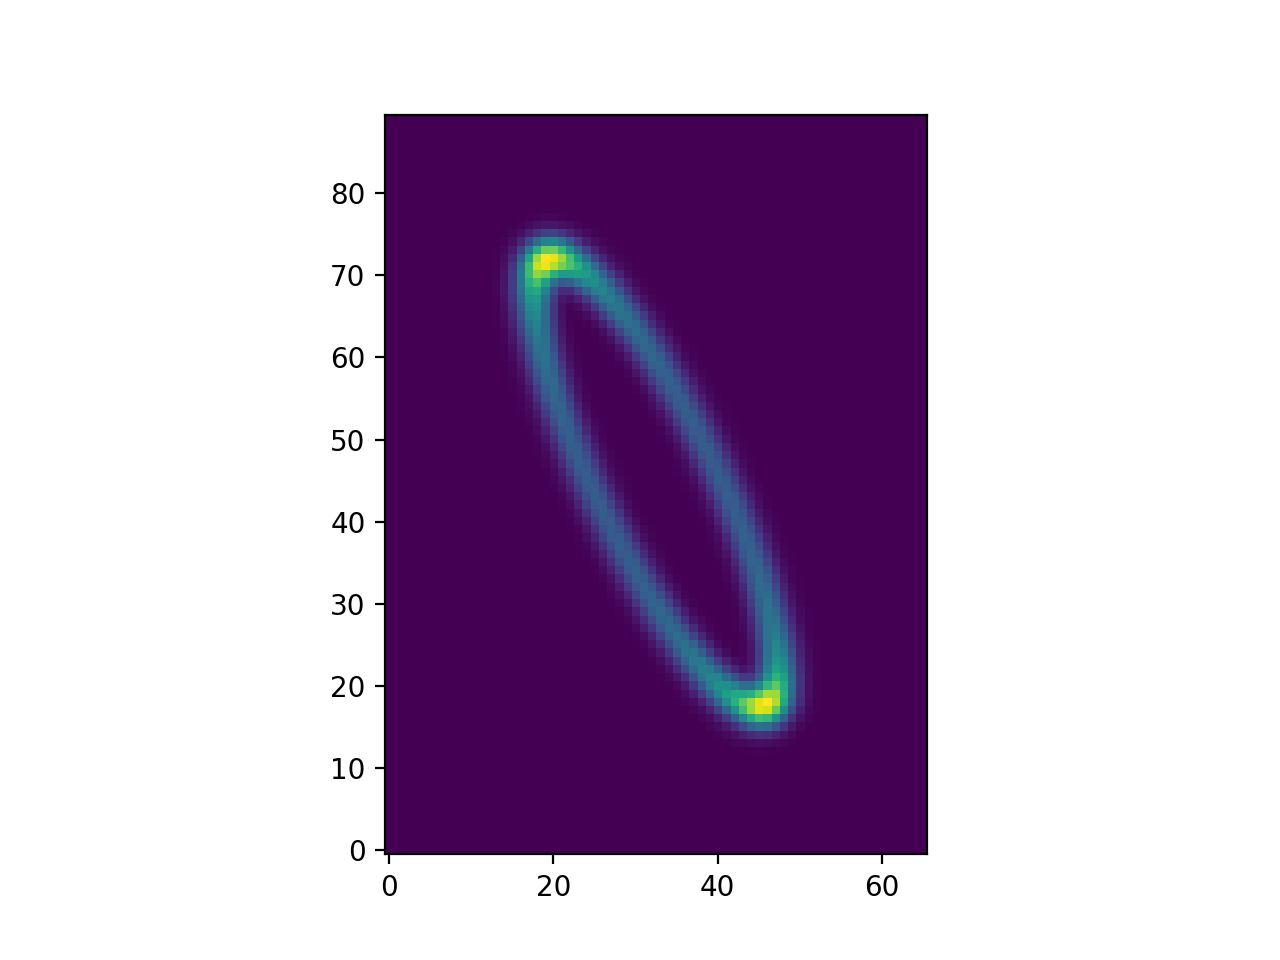

In [14]:
# get the median parameters
p = np.median(sampler.chain[:,burn:,:].reshape((-1,ndim)),axis=0)
s = np.std(sampler.chain[:,burn:,:].reshape((-1,ndim)),axis=0)
print(p)
print(s)

# recompute the limits for the full rotated image
ii.compute_rmax(p)

fig,ax = plt.subplots()
ax.imshow(ii.image(p)[ii.cc], origin='bottom')
fig.savefig(model_name+'/best-'+model_name+'.png')

In [15]:
# save the chains to file
np.savez_compressed(model_name+'/chains-'+model_name+'.npz', sampler.chain, sampler.lnprobability)

In [16]:
# save the visibilities for subtraction from the data
vis_mod = gd.sampleImage(ii.pb_galario * ii.image_galario(p[3:]), dxy, u, v, dRA = p[0]*arcsec, 
                        dDec = p[1]*arcsec, PA = np.deg2rad(p[2]), origin='lower')
np.save(model_name+'/vis-'+model_name+'.npy', vis_mod)

## Creating a map of the residuals
This must be done within CASA. First the script 'residual' is run to subtract the model visibilities created above from the ms we made at the top.
```python
import alma.casa
alma.casa.residual('calibrated.split.cont.w32-t20.ms',
                   'vis-gauss_3d.npy', tb, datacolumn='DATA')
```
Then this is imaged using clean, with something like:
```python
clean(vis='residual.ms',imagename='residual',imsize=[256,256],cell='0.1arcsec',interactive=True)
```
This image can be checked out with viewer(), or saved to a FITS image.

Reading uvtable from hr4796-uv-spw0-w64-t30s.txt ...
Assuming column format: ['u', 'v', 'Re', 'Im', 'weights']
Reading uvtable from hr4796-uv-spw0-w64-t30s.txt ...done


<IPython.core.display.Javascript object>


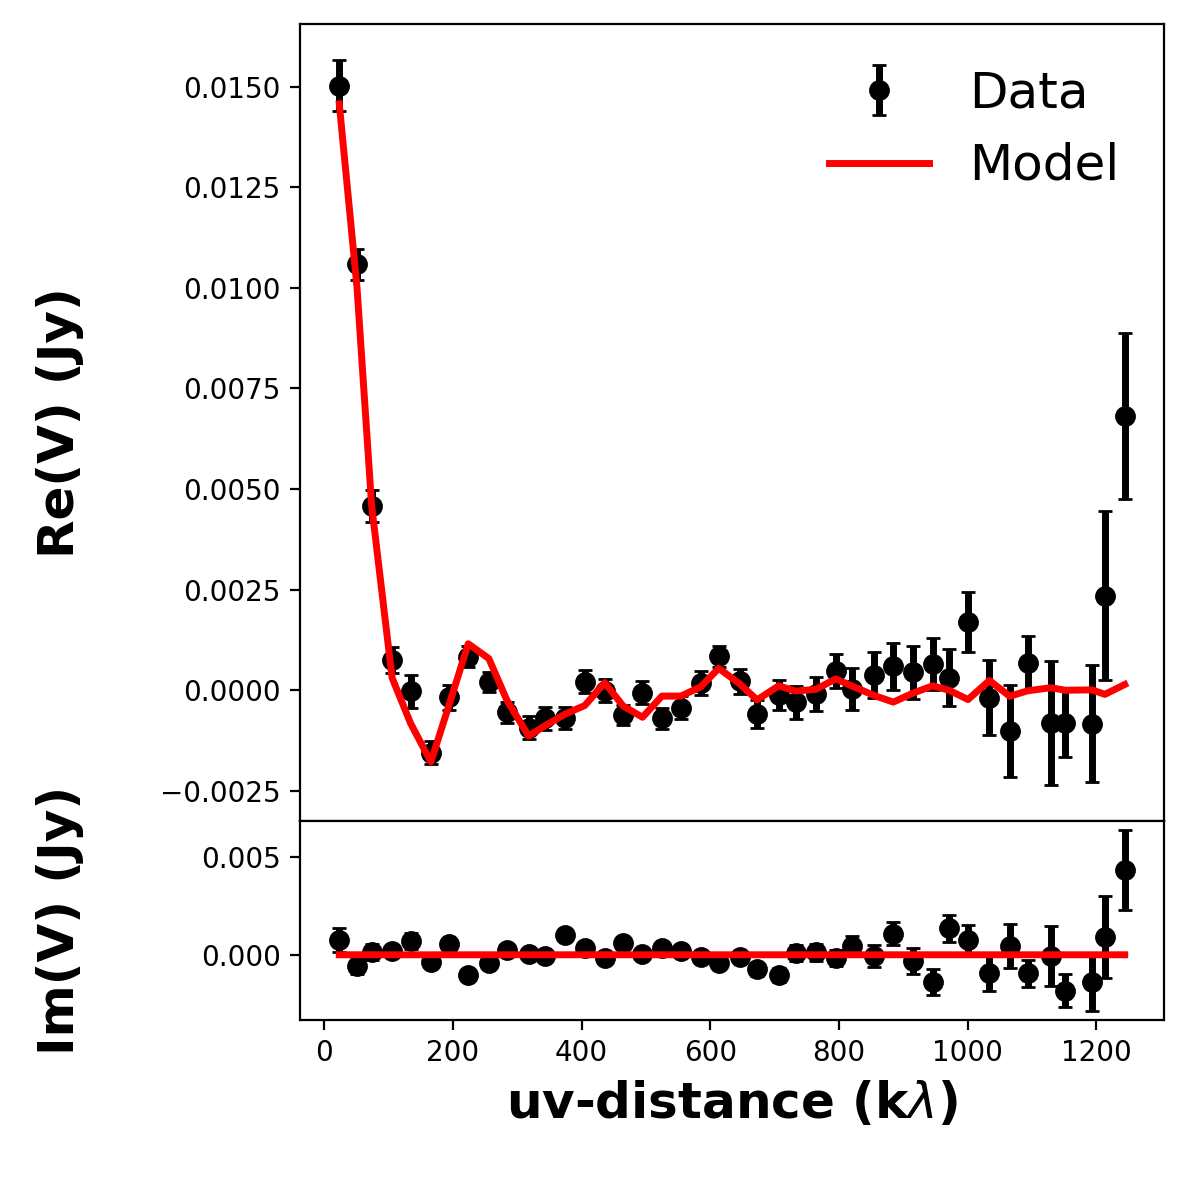

Masking 0 uv bins
Masking 0 uv bins


In [17]:
# make a uv distance plot, needs uvplot from mtazzari
from uvplot.uvtable import UVTable
from uvplot import COLUMNS_V0

uvbin_size = 30e3     # uv-distance bin [wle]

uv = UVTable(filename=uv_file, wle=wavelength, columns=COLUMNS_V0)
uv.apply_phase(-p[0]*arcsec, -p[1]*arcsec)
uv.deproject(np.deg2rad(p[2]), np.deg2rad(p[1]))

uv_mod = UVTable(uvtable=(u*wavelength, v*wavelength, np.real(vis_mod), np.imag(vis_mod), w),
                 wle=wavelength, columns=COLUMNS_V0)
uv_mod.apply_phase(-p[0]*arcsec, -p[1]*arcsec)
uv_mod.deproject(np.deg2rad(p[2]), np.deg2rad(p[1]))

axes = uv.plot(label='Data', uvbin_size=uvbin_size)
uv_mod.plot(label='Model', uvbin_size=uvbin_size, axes=axes, yerr=False, linestyle='-', color='r')
axes[0].figure.savefig(model_name+'/uvplot-'+model_name+'.png')